## Auth-encoder

In [109]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import sys
sys.path.append("../script")

import auth_encoder as enc

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [110]:
dataset = enc.load_csv()

In [111]:
dataset

,BREED,GENDER_01,AGEATSURGERYmo,BODYWEIGHTKG,Taglia,BCS,YEAR,n_luxation,GENERATION,STEMSIZE,...,NECKSIZE,HEADSIZE,ALO,CUPRETROVERSION,STEMANTEVERSIONREAL,RECTUSFEMORISM.RELEASE,first_lux_days_after_thr,DIRECTION,LUX_01,LUX_CR
0,3,0,56.500000,31.6,1,5.0,2021,-1.0,6,0,...,4,1,46.0,15,17.7,0,-1.0,-1.0,0,0
1,8,0,9.400000,40.9,1,5.0,2021,-1.0,6,1,...,5,1,40.0,25,27.7,0,-1.0,-1.0,0,0
2,10,0,15.133333,35.0,1,5.0,2021,-1.0,6,0,...,4,1,42.0,20,27.7,1,-1.0,-1.0,0,0
3,6,0,83.433333,18.7,0,6.0,2021,-1.0,6,2,...,4,0,40.0,18,24.2,0,-1.0,-1.0,0,0
4,5,0,7.533333,36.4,1,4.0,2021,-1.0,6,1,...,5,1,42.0,28,25.9,1,-1.0,-1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,3,0,57.433333,25.0,1,5.0,2010,1.0,4,3,...,3,0,43.0,32,27.7,0,35.0,0.0,1,1
3193,5,1,49.233333,38.0,1,6.0,2009,1.0,4,0,...,4,0,48.0,26,25.9,0,18.0,0.0,1,1
3194,13,0,38.033333,43.0,1,5.0,2008,2.0,3,1,...,4,0,48.0,4,11.5,0,30.0,0.0,1,1
3195,5,1,11.533333,28.0,1,5.0,2001,1.0,2,0,...,4,0,52.0,10,31.3,0,26.0,0.0,1,1


In [112]:
dataset['n_luxation'].value_counts()

n_luxation
-1.0    3056
 1.0      80
 2.0      60
 3.0       1
Name: count, dtype: int64

In [113]:
dataset = dataset.drop(['n_luxation', 'first_lux_days_after_thr', 'DIRECTION'], axis=1)

In [114]:
# Definizione delle feature
feature_cols = ['BREED', 'GENDER_01', 'AGEATSURGERYmo', 'BODYWEIGHTKG', 'Taglia', 'BCS', 
                'YEAR', 'GENERATION', 'STEMSIZE', 'CUPSIZE', 'NECKSIZE', 'HEADSIZE', 'ALO', 
                'CUPRETROVERSION', 'STEMANTEVERSIONREAL', 'RECTUSFEMORISM.RELEASE', 'LUX_CR']

categorical_features = ['BREED', 'GENDER_01', 'Taglia', 'YEAR', 'GENERATION', 'STEMSIZE', 
                        'CUPSIZE', 'NECKSIZE', 'HEADSIZE', 'CUPRETROVERSION', 'RECTUSFEMORISM.RELEASE', 'LUX_CR']
continuous_features = [col for col in feature_cols if col not in categorical_features]

# Separazione del dataset
X = dataset[feature_cols]
y = dataset['LUX_01']

# Dividere i dati in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sovra-campionamento della classe minoritaria (LUX_01 == 1)
minority_class = dataset[dataset['LUX_01'] == 1]
majority_class = dataset[dataset['LUX_01'] == 0]

# Calcolo del numero di campioni da generare per raggiungere il rapporto 2:1
num_positive_samples = minority_class.shape[0]
num_negative_samples = majority_class.shape[0]
total_desired_samples = int(num_negative_samples / 3)
num_samples_to_generate = total_desired_samples - num_positive_samples

# Generazione di nuovi righe con la classe minoritaria mantenendo correlazioni
def generate_new_samples(minority_class, num_samples, continuous_features, categorical_features):
    new_samples = pd.DataFrame(columns=continuous_features + categorical_features)

    for feature in continuous_features:
        other_features = [col for col in continuous_features if col != feature] + categorical_features
        X = minority_class[other_features]
        y = minority_class[feature]

        mlp = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=500, random_state=42)
        mlp.fit(X, y)

        new_feature_values = mlp.predict(np.random.rand(num_samples, len(other_features)))

        new_samples[feature] = new_feature_values

    # Campionamento delle feature categoriche dalla distribuzione esistente
    for col in categorical_features:
        new_samples[col] = np.random.choice(minority_class[col], size=num_samples, replace=True)
    
    new_samples['LUX_01'] = 1  # Assegniamo la classe positiva

    return new_samples

# Generare il numero di nuove righe calcolate
new_samples = generate_new_samples(minority_class, num_samples_to_generate, continuous_features, categorical_features)

# Combinare il dataset originale con le nuove righe generate
balanced_dataset = pd.concat([dataset, new_samples], ignore_index=True)

/home/biso/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/biso/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/biso/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/biso/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/home/biso/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [115]:
balanced_dataset

,BREED,GENDER_01,AGEATSURGERYmo,BODYWEIGHTKG,Taglia,BCS,YEAR,GENERATION,STEMSIZE,CUPSIZE,NECKSIZE,HEADSIZE,ALO,CUPRETROVERSION,STEMANTEVERSIONREAL,RECTUSFEMORISM.RELEASE,LUX_01,LUX_CR
0,3,0,56.500000,31.600000,1,5.000000,2021,6,0,4,4,1,46.000000,15,17.700000,0,0,0
1,8,0,9.400000,40.900000,1,5.000000,2021,6,1,6,5,1,40.000000,25,27.700000,0,0,0
2,10,0,15.133333,35.000000,1,5.000000,2021,6,0,4,4,1,42.000000,20,27.700000,1,0,0
3,6,0,83.433333,18.700000,0,6.000000,2021,6,2,2,4,0,40.000000,18,24.200000,0,0,0
4,5,0,7.533333,36.400000,1,4.000000,2021,6,1,6,5,1,42.000000,28,25.900000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,5,1,-0.904069,-0.924743,1,-0.969348,2006,6,1,6,4,1,-0.962732,14,-0.976832,0,1,0
4070,1,0,-0.907757,-0.913045,1,-0.942453,2005,6,1,3,4,0,-1.015217,9,-0.867870,2,1,0
4071,12,1,-1.150020,-0.917565,1,-0.883111,2011,5,1,2,4,1,-0.888716,8,-0.987373,0,1,1
4072,10,0,-0.928295,-0.937487,1,-0.966103,2021,4,0,6,4,1,-1.100744,27,-1.016862,0,1,0


In [116]:
balanced_dataset['LUX_01'].value_counts()

LUX_01
0    3056
1    1018
Name: count, dtype: int64

In [117]:
dataset

,BREED,GENDER_01,AGEATSURGERYmo,BODYWEIGHTKG,Taglia,BCS,YEAR,GENERATION,STEMSIZE,CUPSIZE,NECKSIZE,HEADSIZE,ALO,CUPRETROVERSION,STEMANTEVERSIONREAL,RECTUSFEMORISM.RELEASE,LUX_01,LUX_CR
0,3,0,56.500000,31.6,1,5.0,2021,6,0,4,4,1,46.0,15,17.7,0,0,0
1,8,0,9.400000,40.9,1,5.0,2021,6,1,6,5,1,40.0,25,27.7,0,0,0
2,10,0,15.133333,35.0,1,5.0,2021,6,0,4,4,1,42.0,20,27.7,1,0,0
3,6,0,83.433333,18.7,0,6.0,2021,6,2,2,4,0,40.0,18,24.2,0,0,0
4,5,0,7.533333,36.4,1,4.0,2021,6,1,6,5,1,42.0,28,25.9,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,3,0,57.433333,25.0,1,5.0,2010,4,3,1,3,0,43.0,32,27.7,0,1,1
3193,5,1,49.233333,38.0,1,6.0,2009,4,0,3,4,0,48.0,26,25.9,0,1,1
3194,13,0,38.033333,43.0,1,5.0,2008,3,1,3,4,0,48.0,4,11.5,0,1,1
3195,5,1,11.533333,28.0,1,5.0,2001,2,0,2,4,0,52.0,10,31.3,0,1,1


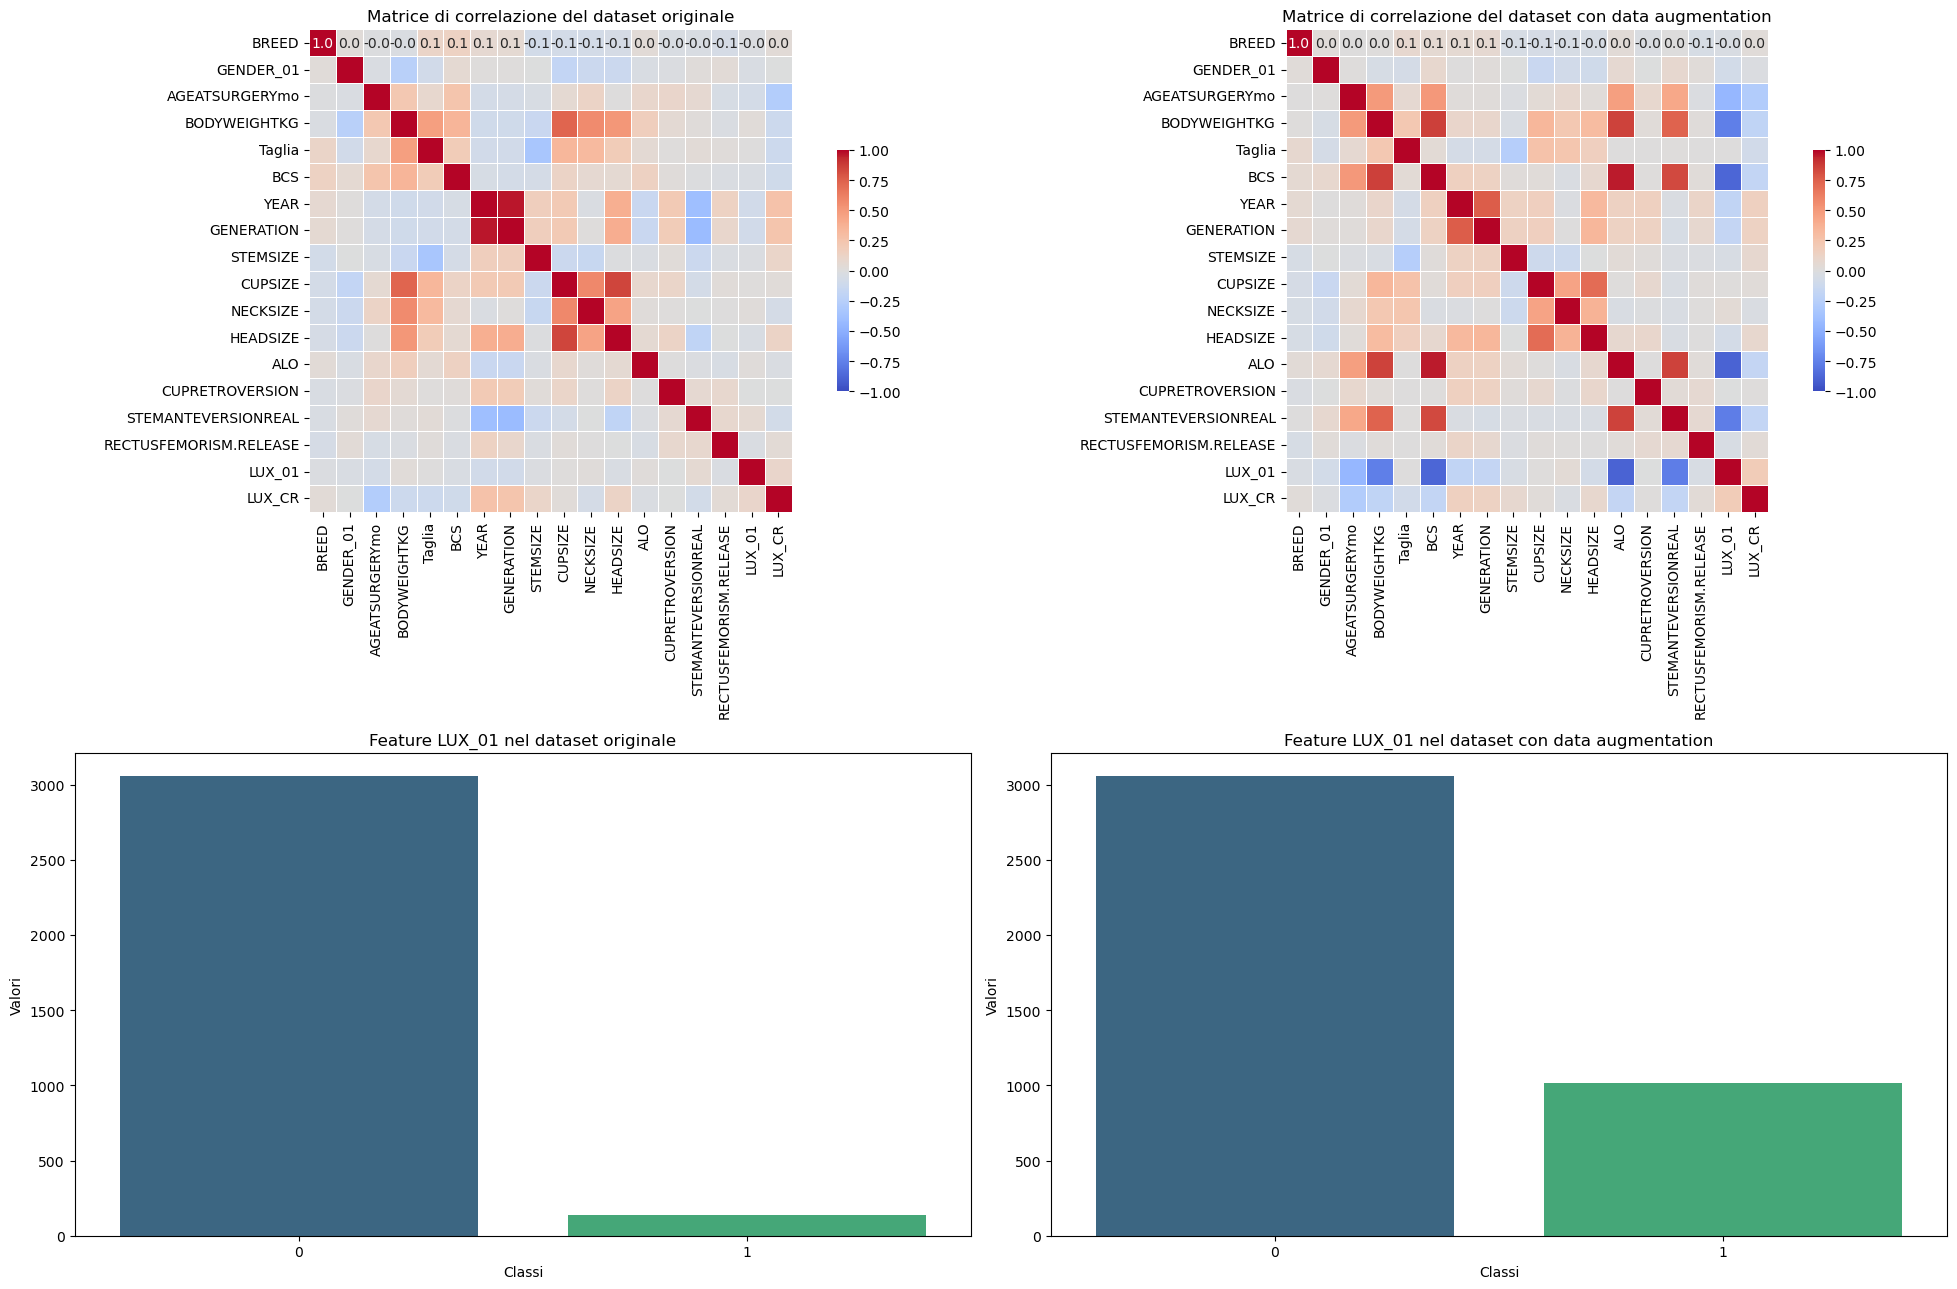

In [118]:
# Creazione della figura con due subplot
fig, axes = plt.subplots(2, 2, figsize=(20, 13))

matrice_corr_drop = dataset.corr()

# Informazioni della heatmap
sns.heatmap(matrice_corr_drop, annot=True, 
                      fmt='.1f', cmap='coolwarm', 
                      square=True, linewidths=.5, 
                      cbar_kws={'shrink': .5},
                      vmin=-1.0, vmax=1.0, ax=axes[0, 0])
axes[0, 0].set_title('Matrice di correlazione del dataset originale')


matrice_corr_drop2 = balanced_dataset.corr()

# Informazioni della heatmap
sns.heatmap(matrice_corr_drop2, annot=True, 
                      fmt='.1f', cmap='coolwarm', 
                      square=True, linewidths=.5, 
                      cbar_kws={'shrink': .5},
                      vmin=-1.0, vmax=1.0, ax=axes[0, 1])
axes[0, 1].set_title('Matrice di correlazione del dataset con data augmentation')


data = dataset['LUX_01'].value_counts()

sns.barplot(x=data.index, y=data.values, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Feature LUX_01 nel dataset originale')
axes[1, 0].set_xlabel('Classi')
axes[1, 0].set_ylabel('Valori')

data2 = balanced_dataset['LUX_01'].value_counts()

sns.barplot(x=data2.index, y=data2.values, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Feature LUX_01 nel dataset con data augmentation')
axes[1, 1].set_xlabel('Classi')
axes[1, 1].set_ylabel('Valori')

# Regolazioni della disposizione
plt.tight_layout()
plt.show()